In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import igraph as ig
import leidenalg as la
from collections import Counter
import networkx as nx
import polars as pl

In [3]:
from sklearn.metrics import adjusted_rand_score, rand_score,normalized_mutual_info_score
from sklearn.datasets import make_blobs
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans,MeanShift, estimate_bandwidth , Birch

In [2]:
df = pl.read_csv("reddit-users.csv")
df

rotoreuters,-0.224305,0.034301,-0.082651,0.004676,0.00696,0.892179,-0.309423,0.570185,0.49211,0.667661,0.379927,-0.701833,0.494844,-0.112651,-0.499859,-0.03113,-0.17902,-0.307026,0.804202,-0.126007,0.298278,0.699318,-0.122089,-0.147698,0.347853,-0.171306,-0.324271,-0.599804,0.423248,-0.56949,-0.824675,-0.568197,-0.515359,-0.281378,-0.631208,0.31375,…,-0.337365,-0.418125,-0.084188,-0.248032,0.35677,0.028407,-0.21356,0.06294,-0.188042,0.431441,-0.472865,0.222936,0.076625,0.285511,0.222161,0.284596,-0.158964,0.182507,0.711164,0.423767,-0.486449,0.403645,-0.716357,-0.359746,0.063134,0.646768,-0.287045,-0.380348,-0.14416,-0.289317,0.471727,-0.174092,0.534364,0.218821,0.269216,-0.412621,-0.469088
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""fiplefip""",-0.306765,0.259314,-0.950335,0.560013,-0.364981,0.073359,-0.256642,-0.348088,-0.030323,-0.284338,0.377343,-0.358473,0.559322,0.062051,0.099554,0.46136,-0.273855,-0.274918,0.725871,-0.230823,-0.436114,0.186223,-0.004017,0.297142,-0.066631,0.16217,-0.364509,0.229731,-0.151828,0.22865,0.171403,-0.334804,-0.408777,-0.165566,0.274575,-0.265074,…,-0.007571,-0.811709,0.228903,-0.525756,0.513215,-0.197298,-0.706438,-0.42467,0.410469,0.16759,0.003496,0.130472,-0.59432,-0.076453,0.671613,-0.53084,0.171624,-0.14149,0.264164,-0.338885,-0.125357,-0.206496,0.660746,-0.327274,0.188642,0.439133,-0.158999,-0.432182,-0.769793,-0.434484,0.268733,-0.163076,-0.455654,0.41656,-0.219805,-0.568944,-0.477788
"""amici_ursi""",-0.234556,0.60916,-0.065395,-0.212264,0.269761,-0.562834,-0.455435,-0.349673,0.391979,0.36878,-0.332526,-0.612227,0.881066,-0.310739,0.338838,-0.069625,-0.223117,0.319171,0.984606,0.245857,0.85169,-0.294353,0.134919,-0.026722,0.360474,0.187247,-0.023172,0.356334,-0.13018,-0.085904,-0.098366,0.615505,0.404617,0.230763,-0.305228,0.863486,…,-0.144152,-0.504473,-0.384659,-0.827701,0.187106,-0.053623,-0.003742,-0.774822,0.251569,-0.868102,-0.863559,-0.002648,0.084968,0.187232,-0.172234,0.728021,-0.188714,0.579466,-0.209696,0.877766,-0.14669,-0.592308,-0.037788,-0.548592,0.301136,0.873749,0.233379,0.622636,0.23427,0.083597,-0.647548,0.103007,0.344196,0.140004,0.579194,-0.046483,-0.705478
"""unremovable""",0.253033,0.548086,-0.538728,0.375164,-0.129068,0.307664,-0.047697,-0.492977,0.224615,0.073754,-0.286705,0.011221,0.601635,-0.535227,-0.487574,-0.058265,-0.224699,0.003262,0.889734,-0.533337,-0.315974,0.377092,0.833714,-0.320869,0.634363,0.197973,0.561948,0.049643,0.112593,0.308731,-0.208679,0.16751,0.39875,0.018139,0.002018,0.76555,…,-0.180951,0.170767,-0.143426,-0.521084,-0.232333,0.294799,-0.117459,0.053756,0.421318,0.052284,-0.262025,0.164859,-0.848743,0.55363,0.349082,-0.135026,0.635478,-0.2771,0.335012,0.315789,0.046486,0.604992,-0.487021,-0.582454,-0.287221,0.907134,-0.38617,0.165165,-0.21692,-0.414641,-0.144242,0.18506,0.356242,0.095848,0.40301,-0.320782,-0.735368
"""CDRE_64""",-0.008056,0.05056,-0.295054,-0.046483,0.04242,0.345231,0.075705,-0.198281,0.139585,0.174352,0.134547,-0.214878,0.495939,-0.149515,-0.077004,0.404769,-0.250609,-0.405186,0.347727,-0.11806,0.313708,-0.187699,0.101371,-0.073235,0.188572,0.095709,-0.108428,0.193696,-0.135239,-0.310914,-0.224337,0.133148,-0.112955,-0.063444,-0.525183,0.218605,…,-0.270214,-0.122056,-0.028533,-0.358274,0.002222,-0.025049,-0.344229,-0.11333,0.094965,-0.26357,-0.364839,-0.003944,-0.093974,-0.101392,0.161158,0.124243,-0.125217,-0.032501,0.328473,0.337958,-0.156932,0.002218,-0.24986,-0.15847,0.123921,0.427048,-0.048551,-0.221219,-0.474621,-0.149465,-0.156034,-0.115828,-0.170805,0.284541,-0.14477,-0.05001,-0.341634
"""noeatnosleep""",0.313406,0.702873,0.076761,-0.511176,0.374304,-0.247656,0.148855,-0.616189,-0.144205,0.222953,-0.183565,-0.363646,0.869296,-0.146551,0.176667,-0.178732,0.01879

In [4]:
usernames = df["rotoreuters"].to_list()
X = df.drop("rotoreuters")
X

-0.224305,0.034301,-0.082651,0.004676,0.00696,0.892179,-0.309423,0.570185,0.49211,0.667661,0.379927,-0.701833,0.494844,-0.112651,-0.499859,-0.03113,-0.17902,-0.307026,0.804202,-0.126007,0.298278,0.699318,-0.122089,-0.147698,0.347853,-0.171306,-0.324271,-0.599804,0.423248,-0.56949,-0.824675,-0.568197,-0.515359,-0.281378,-0.631208,0.31375,0.43415,…,-0.337365,-0.418125,-0.084188,-0.248032,0.35677,0.028407,-0.21356,0.06294,-0.188042,0.431441,-0.472865,0.222936,0.076625,0.285511,0.222161,0.284596,-0.158964,0.182507,0.711164,0.423767,-0.486449,0.403645,-0.716357,-0.359746,0.063134,0.646768,-0.287045,-0.380348,-0.14416,-0.289317,0.471727,-0.174092,0.534364,0.218821,0.269216,-0.412621,-0.469088
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.306765,0.259314,-0.950335,0.560013,-0.364981,0.073359,-0.256642,-0.348088,-0.030323,-0.284338,0.377343,-0.358473,0.559322,0.062051,0.099554,0.46136,-0.273855,-0.274918,0.725871,-0.230823,-0.436114,0.186223,-0.004017,0.297142,-0.066631,0.16217,-0.364509,0.229731,-0.151828,0.22865,0.171403,-0.334804,-0.408777,-0.165566,0.274575,-0.265074,0.429774,…,-0.007571,-0.811709,0.228903,-0.525756,0.513215,-0.197298,-0.706438,-0.42467,0.410469,0.16759,0.003496,0.130472,-0.59432,-0.076453,0.671613,-0.53084,0.171624,-0.14149,0.264164,-0.338885,-0.125357,-0.206496,0.660746,-0.327274,0.188642,0.439133,-0.158999,-0.432182,-0.769793,-0.434484,0.268733,-0.163076,-0.455654,0.41656,-0.219805,-0.568944,-0.477788
-0.234556,0.60916,-0.065395,-0.212264,0.269761,-0.562834,-0.455435,-0.349673,0.391979,0.36878,-0.332526,-0.612227,0.881066,-0.310739,0.338838,-0.069625,-0.223117,0.319171,0.984606,0.245857,0.85169,-0.294353,0.134919,-0.026722,0.360474,0.187247,-0.023172,0.356334,-0.13018,-0.085904,-0.098366,0.615505,0.404617,0.230763,-0.305228,0.863486,0.072753,…,-0.144152,-0.504473,-0.384659,-0.827701,0.187106,-0.053623,-0.003742,-0.774822,0.251569,-0.868102,-0.863559,-0.002648,0.084968,0.187232,-0.172234,0.728021,-0.188714,0.579466,-0.209696,0.877766,-0.14669,-0.592308,-0.037788,-0.548592,0.301136,0.873749,0.233379,0.622636,0.23427,0.083597,-0.647548,0.103007,0.344196,0.140004,0.579194,-0.046483,-0.705478
0.253033,0.548086,-0.538728,0.375164,-0.129068,0.307664,-0.047697,-0.492977,0.224615,0.073754,-0.286705,0.011221,0.601635,-0.535227,-0.487574,-0.058265,-0.224699,0.003262,0.889734,-0.533337,-0.315974,0.377092,0.833714,-0.320869,0.634363,0.197973,0.561948,0.049643,0.112593,0.308731,-0.208679,0.16751,0.39875,0.018139,0.002018,0.76555,0.261157,…,-0.180951,0.170767,-0.143426,-0.521084,-0.232333,0.294799,-0.117459,0.053756,0.421318,0.052284,-0.262025,0.164859,-0.848743,0.55363,0.349082,-0.135026,0.635478,-0.2771,0.335012,0.315789,0.046486,0.604992,-0.487021,-0.582454,-0.287221,0.907134,-0.38617,0.165165,-0.21692,-0.414641,-0.144242,0.18506,0.356242,0.095848,0.40301,-0.320782,-0.735368
-0.008056,0.05056,-0.295054,-0.046483,0.04242,0.345231,0.075705,-0.198281,0.139585,0.174352,0.134547,-0.214878,0.495939,-0.149515,-0.077004,0.404769,-0.250609,-0.405186,0.347727,-0.11806,0.313708,-0.187699,0.101371,-0.073235,0.188572,0.095709,-0.108428,0.193696,-0.135239,-0.310914,-0.224337,0.133148,-0.112955,-0.063444,-0.525183,0.218605,0.149472,…,-0.270214,-0.122056,-0.028533,-0.358274,0.002222,-0.025049,-0.344229,-0.11333,0.094965,-0.26357,-0.364839,-0.003944,-0.093974,-0.101392,0.161158,0.124243,-0.125217,-0.032501,0.328473,0.337958,-0.156932,0.002218,-0.24986,-0.15847,0.123921,0.427048,-0.048551,-0.221219,-0.474621,-0.149465,-0.156034,-0.115828,-0.170805,0.284541,-0.14477,-0.05001,-0.341634
0.313406,0.702873,0.076761,-0.511176,0.374304,-0.247656,0.148855,-0.616189,-0.144205,0.222953,-0.183565,-0.363646,0.869296,-0.146551,0.176667,-0.178732,0.018797,-0.18148,1.014249,-0.096242,0.79333,0.656905,-0.1

In [5]:
from scipy.sparse import csr_matrix

In [6]:
k = 20

nbrs = NearestNeighbors(n_neighbors=k, metric='cosine').fit(X)
distances, indices = nbrs.kneighbors(X)

In [7]:
rows = np.repeat(np.arange(len(X)), k)
cols = indices.flatten()
vals = 1 - distances.flatten()        # تبدیل distance → similarity

A = sp.csr_matrix((vals, (rows, cols)), shape=(len(X), len(X)))
A

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2367600 stored elements and shape (118380, 118380)>

In [8]:
print("نوع داده:", type(A))
print("شکل ماتریس:", A.shape)
print("تعداد عناصر غیر صفر:", A.nnz)
print("تراکم (density):", A.nnz / (A.shape[0] * A.shape[1]))

نوع داده: <class 'scipy.sparse._csr.csr_matrix'>
شکل ماتریس: (118380, 118380)
تعداد عناصر غیر صفر: 2367600
تراکم (density): 0.00016894745734076703


#### ماتریس رو متقارن میکنیم 

In [9]:
symmetric_matrix = A.maximum(A.T)
symmetric_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 4416036 stored elements and shape (118380, 118380)>

In [10]:
print("نوع داده:", type(symmetric_matrix))
print("شکل ماتریس:", symmetric_matrix.shape)
print("تعداد عناصر غیر صفر:", symmetric_matrix.nnz)
print("تراکم (density):", symmetric_matrix.nnz / (symmetric_matrix.shape[0] * symmetric_matrix.shape[1]))

نوع داده: <class 'scipy.sparse._csr.csr_matrix'>
شکل ماتریس: (118380, 118380)
تعداد عناصر غیر صفر: 4416036
تراکم (density): 0.0003151199753865904


In [11]:
# اندیس‌های عناصر غیرصفری ماتریس اسپارس A را برمی‌گرداند.
records, fields = A.nonzero()
#مقادیر غیرصفری ماتریس A را برمی‌گرداند.
weights = A.data


#ساخت گراف igraph از ماتریس
g = ig.Graph(n=A.shape[0], edges=list(zip(records, fields)))

# ویژگی وزن هر یال را برای مجموعه یال‌های گراف تنظیم می‌کند.
g.es["weight"] = weights

# اجرای leiden
partition = la.find_partition(g, la.RBConfigurationVertexPartition, weights="weight")
partition

In [13]:
print(partition)

Clustering with 118380 elements and 38 clusters
[ 0] 17, 40, 141, 168, 244, 286, 363, 397, 560, 617, 645, 662, 711, 726, 756,
     784, 855, 894, 940, 950, 963, 1004, 1021, 1038, 1048, 1077, 1090, 1123,
     1124, 1139, 1142, 1198, 1212, 1237, 1239, 1249, 1345, 1451, 1470, 1502,
     1513, 1567, 1627, 1729, 1773, 1969, 1987, 2034, 2040, 2095, 2110, 2176,
     2177, 2251, 2276, 2291, 2307, 2324, 2330, 2340, 2363, 2393, 2418, 2456,
     2459, 2543, 2546, 2566, 2574, 2583, 2593, 2607, 2657, 2705, 2706, 2725,
     2759, 2768, 2769, 2776, 2777, 2784, 2790, 2833, 2864, 2932, 2940, 2996,
     2998, 2999, 3004, 3018, 3021, 3022, 3064, 3125, 3165, 3180, 3188, 3198,
     3203, 3225, 3249, 3268, 3276, 3294, 3388, 3423, 3481, 3499, 3509, 3556,
     3567, 3597, 3624, 3628, 3651, 3665, 3674, 3677, 3697, 3742, 3760, 3792,
     3800, 3802, 3826, 3836, 3871, 3878, 3951, 3952, 3961, 3970, 3986, 4020,
     4028, 4061, 4073, 4099, 4123, 4156, 4171, 4234, 4240, 4271, 4319, 4342,
     4379, 4395, 4397, 4407

In [17]:
import matplotlib.pyplot as plt

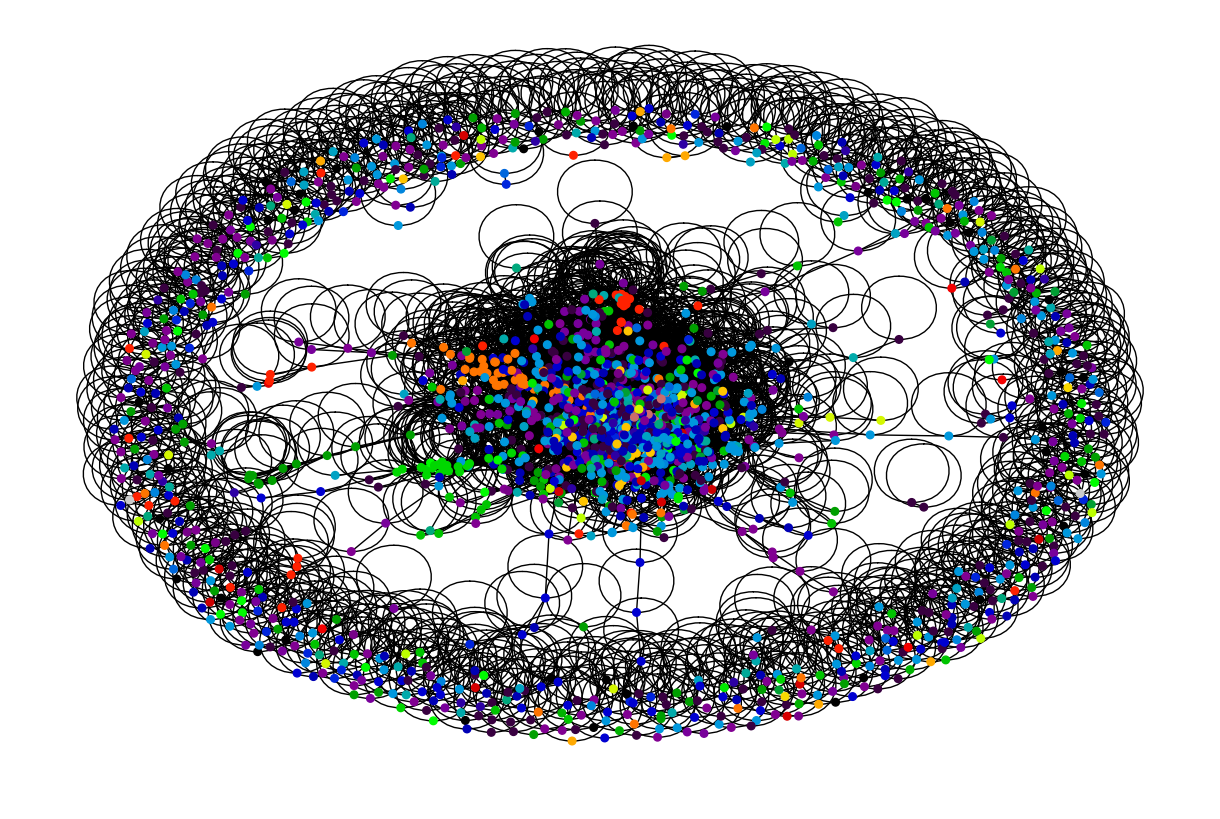

In [18]:
# انتخاب زیرگراف از igraph
sample = list(range(2000))
H = g.subgraph(sample)

# تبدیل به networkx
H_nx = nx.Graph()
H_nx.add_nodes_from(range(H.vcount()))
H_nx.add_edges_from(H.get_edgelist())

# گرفتن لیبل اجتماع هر رأس از partition
membership = partition.membership

# رنگ‌دهی بر اساس شماره کلاستر
colors = [membership[v] for v in H.vs.indices[:H.vcount()]]

plt.figure(figsize=(12, 8))
nx.draw(
    H_nx,
    with_labels=False,
    node_size=30,
    node_color=colors,
    cmap=plt.cm.nipy_spectral   # پالت بزرگ برای ۳۸ کلاستر
)
plt.show()

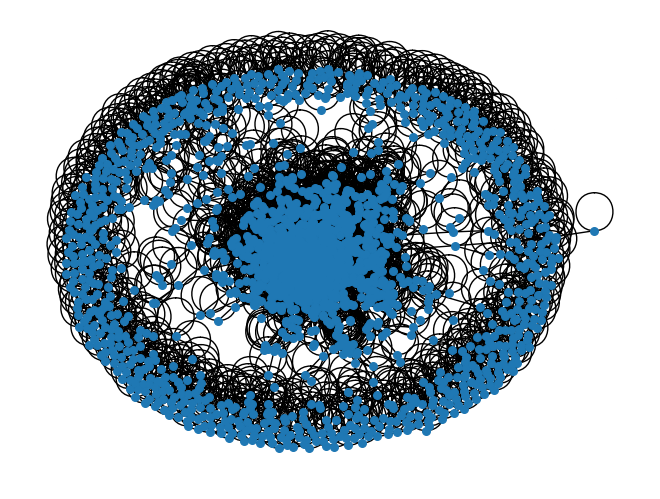

In [16]:
sample = list(range(2000))
H = g.subgraph(sample)

# تبدیل igraph به networkx
H_nx = H.to_networkx()

nx.draw(H_nx, with_labels=False, node_size=30)

In [23]:
from networkx.algorithms.community.quality import modularity

In [33]:
labels_pred = partition.membership
print(labels_pred)

[12, 1, 11, 1, 1, 11, 28, 25, 6, 5, 4, 3, 12, 6, 17, 1, 1, 0, 6, 6, 6, 29, 30, 11, 11, 30, 11, 31, 7, 3, 2, 21, 17, 11, 1, 15, 1, 6, 1, 25, 0, 2, 6, 19, 20, 31, 11, 1, 17, 28, 3, 11, 25, 6, 11, 13, 11, 1, 11, 1, 11, 1, 6, 11, 7, 6, 3, 17, 11, 4, 6, 6, 6, 11, 6, 6, 11, 1, 11, 30, 6, 11, 3, 11, 11, 11, 6, 1, 11, 17, 1, 11, 1, 17, 30, 31, 30, 5, 11, 1, 6, 6, 11, 21, 11, 11, 11, 30, 6, 1, 4, 6, 11, 2, 1, 6, 30, 19, 4, 28, 11, 1, 17, 11, 3, 17, 1, 6, 30, 37, 17, 11, 20, 6, 12, 4, 22, 1, 1, 11, 3, 0, 19, 2, 24, 1, 17, 3, 11, 11, 1, 3, 11, 30, 6, 11, 28, 17, 11, 1, 1, 11, 7, 6, 1, 1, 4, 1, 0, 30, 30, 6, 22, 11, 6, 11, 11, 6, 11, 17, 6, 4, 1, 30, 1, 31, 6, 30, 17, 3, 1, 1, 11, 10, 19, 1, 3, 6, 28, 11, 1, 11, 11, 1, 24, 3, 25, 11, 13, 13, 5, 11, 3, 11, 19, 6, 11, 11, 3, 11, 1, 13, 30, 11, 19, 17, 6, 6, 11, 17, 24, 6, 4, 14, 3, 1, 6, 35, 11, 22, 31, 6, 7, 6, 0, 11, 7, 1, 6, 3, 4, 7, 30, 16, 14, 22, 1, 22, 20, 19, 11, 11, 4, 1, 11, 25, 31, 6, 17, 11, 1, 1, 7, 28, 3, 6, 3, 11, 7, 11, 6, 4, 1, 3, 6

In [36]:
df = df.with_columns(
    pl.Series(name="leiden_cluster", values=labels_pred)
)
df

rotoreuters,-0.224305,0.034301,-0.082651,0.004676,0.00696,0.892179,-0.309423,0.570185,0.49211,0.667661,0.379927,-0.701833,0.494844,-0.112651,-0.499859,-0.03113,-0.17902,-0.307026,0.804202,-0.126007,0.298278,0.699318,-0.122089,-0.147698,0.347853,-0.171306,-0.324271,-0.599804,0.423248,-0.56949,-0.824675,-0.568197,-0.515359,-0.281378,-0.631208,0.31375,…,-0.418125,-0.084188,-0.248032,0.35677,0.028407,-0.21356,0.06294,-0.188042,0.431441,-0.472865,0.222936,0.076625,0.285511,0.222161,0.284596,-0.158964,0.182507,0.711164,0.423767,-0.486449,0.403645,-0.716357,-0.359746,0.063134,0.646768,-0.287045,-0.380348,-0.14416,-0.289317,0.471727,-0.174092,0.534364,0.218821,0.269216,-0.412621,-0.469088,leiden_cluster
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
"""fiplefip""",-0.306765,0.259314,-0.950335,0.560013,-0.364981,0.073359,-0.256642,-0.348088,-0.030323,-0.284338,0.377343,-0.358473,0.559322,0.062051,0.099554,0.46136,-0.273855,-0.274918,0.725871,-0.230823,-0.436114,0.186223,-0.004017,0.297142,-0.066631,0.16217,-0.364509,0.229731,-0.151828,0.22865,0.171403,-0.334804,-0.408777,-0.165566,0.274575,-0.265074,…,-0.811709,0.228903,-0.525756,0.513215,-0.197298,-0.706438,-0.42467,0.410469,0.16759,0.003496,0.130472,-0.59432,-0.076453,0.671613,-0.53084,0.171624,-0.14149,0.264164,-0.338885,-0.125357,-0.206496,0.660746,-0.327274,0.188642,0.439133,-0.158999,-0.432182,-0.769793,-0.434484,0.268733,-0.163076,-0.455654,0.41656,-0.219805,-0.568944,-0.477788,12
"""amici_ursi""",-0.234556,0.60916,-0.065395,-0.212264,0.269761,-0.562834,-0.455435,-0.349673,0.391979,0.36878,-0.332526,-0.612227,0.881066,-0.310739,0.338838,-0.069625,-0.223117,0.319171,0.984606,0.245857,0.85169,-0.294353,0.134919,-0.026722,0.360474,0.187247,-0.023172,0.356334,-0.13018,-0.085904,-0.098366,0.615505,0.404617,0.230763,-0.305228,0.863486,…,-0.504473,-0.384659,-0.827701,0.187106,-0.053623,-0.003742,-0.774822,0.251569,-0.868102,-0.863559,-0.002648,0.084968,0.187232,-0.172234,0.728021,-0.188714,0.579466,-0.209696,0.877766,-0.14669,-0.592308,-0.037788,-0.548592,0.301136,0.873749,0.233379,0.622636,0.23427,0.083597,-0.647548,0.103007,0.344196,0.140004,0.579194,-0.046483,-0.705478,1
"""unremovable""",0.253033,0.548086,-0.538728,0.375164,-0.129068,0.307664,-0.047697,-0.492977,0.224615,0.073754,-0.286705,0.011221,0.601635,-0.535227,-0.487574,-0.058265,-0.224699,0.003262,0.889734,-0.533337,-0.315974,0.377092,0.833714,-0.320869,0.634363,0.197973,0.561948,0.049643,0.112593,0.308731,-0.208679,0.16751,0.39875,0.018139,0.002018,0.76555,…,0.170767,-0.143426,-0.521084,-0.232333,0.294799,-0.117459,0.053756,0.421318,0.052284,-0.262025,0.164859,-0.848743,0.55363,0.349082,-0.135026,0.635478,-0.2771,0.335012,0.315789,0.046486,0.604992,-0.487021,-0.582454,-0.287221,0.907134,-0.38617,0.165165,-0.21692,-0.414641,-0.144242,0.18506,0.356242,0.095848,0.40301,-0.320782,-0.735368,11
"""CDRE_64""",-0.008056,0.05056,-0.295054,-0.046483,0.04242,0.345231,0.075705,-0.198281,0.139585,0.174352,0.134547,-0.214878,0.495939,-0.149515,-0.077004,0.404769,-0.250609,-0.405186,0.347727,-0.11806,0.313708,-0.187699,0.101371,-0.073235,0.188572,0.095709,-0.108428,0.193696,-0.135239,-0.310914,-0.224337,0.133148,-0.112955,-0.063444,-0.525183,0.218605,…,-0.122056,-0.028533,-0.358274,0.002222,-0.025049,-0.344229,-0.11333,0.094965,-0.26357,-0.364839,-0.003944,-0.093974,-0.101392,0.161158,0.124243,-0.125217,-0.032501,0.328473,0.337958,-0.156932,0.002218,-0.24986,-0.15847,0.123921,0.427048,-0.048551,-0.221219,-0.474621,-0.149465,-0.156034,-0.115828,-0.170805,0.284541,-0.14477,-0.05001,-0.341634,1
"""noeatnosleep""",0.313406,0.702873,0.076761,-0.511176,0.374304,-0.247656,0.148855,-0.616189,-0.144205,0.222953,-0.183565,-0.363646,0.869296,-0.146551,0.176667,-0.178732,0.018797,-0.18148,1.014249,-0.09

In [38]:
labels_true = df["leiden_cluster"].to_numpy()
labels_true

array([12,  1, 11, ...,  3,  8,  7], shape=(118380,))

#### Rand Index , Adjusted Rand Index (ARI) , Modularity ,NMI (Normalized Mutual Information) , Purity

In [24]:
class EvaluationMetrics:
    def __init__(self, graph=None, partition=None):
        """
        graph: NetworkX Graph
        partition: dictionary {node: community_id}
        """
        self.graph = graph
        self.partition = partition

        # metrics
        self.y_true = None
        self.y_pred = None

        self._purity = None
        self._nmi = None
        self._ari = None
        self._ri = None
        self._modularity = None

    # Purity
    def _compute_purity(self):
        y_true = np.asarray(self.y_true)
        y_pred = np.asarray(self.y_pred)

        clusters = np.unique(y_pred)
        N = len(y_true)
        total = 0

        for c in clusters:
            idx = np.where(y_pred == c)[0]
            true_labels = y_true[idx]
            if len(true_labels) == 0:
                continue
            most_common = Counter(true_labels).most_common(1)[0][1]
            total += most_common

        return total / N

    # MAIN FIT
    def fit(self, y_true, y_pred):
        """
        y_true, y_pred should be 1D arrays
        """
        self.y_true = np.asarray(list(y_true))
        self.y_pred = np.asarray(list(y_pred))

        # purity
        self._purity = self._compute_purity()

        # nmi
        self._nmi = normalized_mutual_info_score(self.y_true, self.y_pred)

        # ari
        self._ari = adjusted_rand_score(self.y_true, self.y_pred)

        # ri
        self._ri = rand_score(self.y_true, self.y_pred)

        # modularity (NetworkX)
        if self.graph is not None and self.partition is not None:
            # partition must be list of sets
            communities = {}
            for node, com in self.partition.items():
                communities.setdefault(com, set()).add(node)
            community_list = list(communities.values())

            try:
                self._modularity = modularity(self.graph, community_list, weight="weight")
            except:
                self._modularity = None

        return self

    # GETTERS
    def score_purity(self):
        return self._purity

    def score_nmi(self):
        return self._nmi

    def score_ari(self):
        return self._ari

    def score_ri(self):
        return self._ri

    def score_modularity(self):
        return self._modularity

In [39]:
metrics = EvaluationMetrics(graph=g, partition=partition)

metrics.fit(labels_true, labels_pred)

print("Purity:", metrics.score_purity())
print("NMI:", metrics.score_nmi())
print("ARI:", metrics.score_ari())
print("RI:", metrics.score_ri())
print("Modularity:", round(metrics.score_modularity(),3))

AttributeError: 'RBConfigurationVertexPartition' object has no attribute 'items'